# CPTAC UCEC evaluation

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

colorblind_colors = {
    "G1": "#1E88E5",  # Blue
    "G2": "#FFC107",  # Vermillion
    "G3": "#D81B60",  # Black
}

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()

# Directories and data paths
folds_dir = "./models/ckpts/CPTAC_UCEC_titan_medimsight_trainmixed15"
test_path = "./data/processed/processed_CPTACUCEC_survival/k=all.tsv"

n_folds = 4
fold_cindices = []

for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    
    # Load model checkpoint
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("ct_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Load test data
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,
        split="test",             # <-- split should be “test”, not “train”
        ct_path="../MedImageInsights/embeddings_cptacucec",
        wsi_path="../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    hazards_all, times_all, events_all = [], [], []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times = batch["survtime"]
            events = batch["censor"]

            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    hazards_all = np.concatenate(hazards_all)
    times_all = np.concatenate(times_all)
    events_all = np.concatenate(events_all)

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

    # Split into high/low risk
    order = np.argsort(hazards_all)
    half = len(order) // 2
    low_idx, high_idx = order[:half], order[half:]
    low_mask = np.zeros_like(order, dtype=bool)
    high_mask = np.zeros_like(order, dtype=bool)
    low_mask[low_idx] = True
    high_mask[high_idx] = True

    # Create and save individual KM plot
    fig, ax = plt.subplots(figsize=(6, 5))
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask], events_all[low_mask], label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")
    kmf_low.plot_survival_function(ax=ax, color=colorblind_colors["G1"])
    kmf_high.plot_survival_function(ax=ax, color=colorblind_colors["G3"])

    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"(p = {results.p_value:.3e})",fontsize=18)
    ax.set_xlabel("Time", fontsize=16)
    ax.set_ylabel("Survival Probability", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.legend(fontsize=14)
    # Save each fold figure as PDF
    output_dir = "./plots"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f"UCECmissing_km_plot_fold_{fold}.pdf")
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(pdf_path)
    
    plt.close(fig)
    print(f"Saved Kaplan–Meier plot for fold {fold} to {pdf_path}")

# Aggregate C-Index
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0
Fold 0 Mean C-Index: 0.2500


/tmp/ipykernel_2709457/4037562480.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Saved Kaplan–Meier plot for fold 0 to ./plots/UCECmissing_km_plot_fold_0.pdf

Evaluating Fold 1
Fold 1 Mean C-Index: 0.1000


/tmp/ipykernel_2709457/4037562480.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Saved Kaplan–Meier plot for fold 1 to ./plots/UCECmissing_km_plot_fold_1.pdf

Evaluating Fold 2
Fold 2 Mean C-Index: 0.1429


/tmp/ipykernel_2709457/4037562480.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Saved Kaplan–Meier plot for fold 2 to ./plots/UCECmissing_km_plot_fold_2.pdf

Evaluating Fold 3
Fold 3 Mean C-Index: 0.4000


/tmp/ipykernel_2709457/4037562480.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Saved Kaplan–Meier plot for fold 3 to ./plots/UCECmissing_km_plot_fold_3.pdf

Overall Mean C-Index across folds: 0.2232 ± 0.1337



Evaluating Fold 0


/tmp/ipykernel_2709457/2443969508.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 0 Mean C-Index: 0.2500

Evaluating Fold 1


/tmp/ipykernel_2709457/2443969508.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 1 Mean C-Index: 0.1000

Evaluating Fold 2


/tmp/ipykernel_2709457/2443969508.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 2 Mean C-Index: 0.1667

Evaluating Fold 3


/tmp/ipykernel_2709457/2443969508.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 3 Mean C-Index: 0.2500


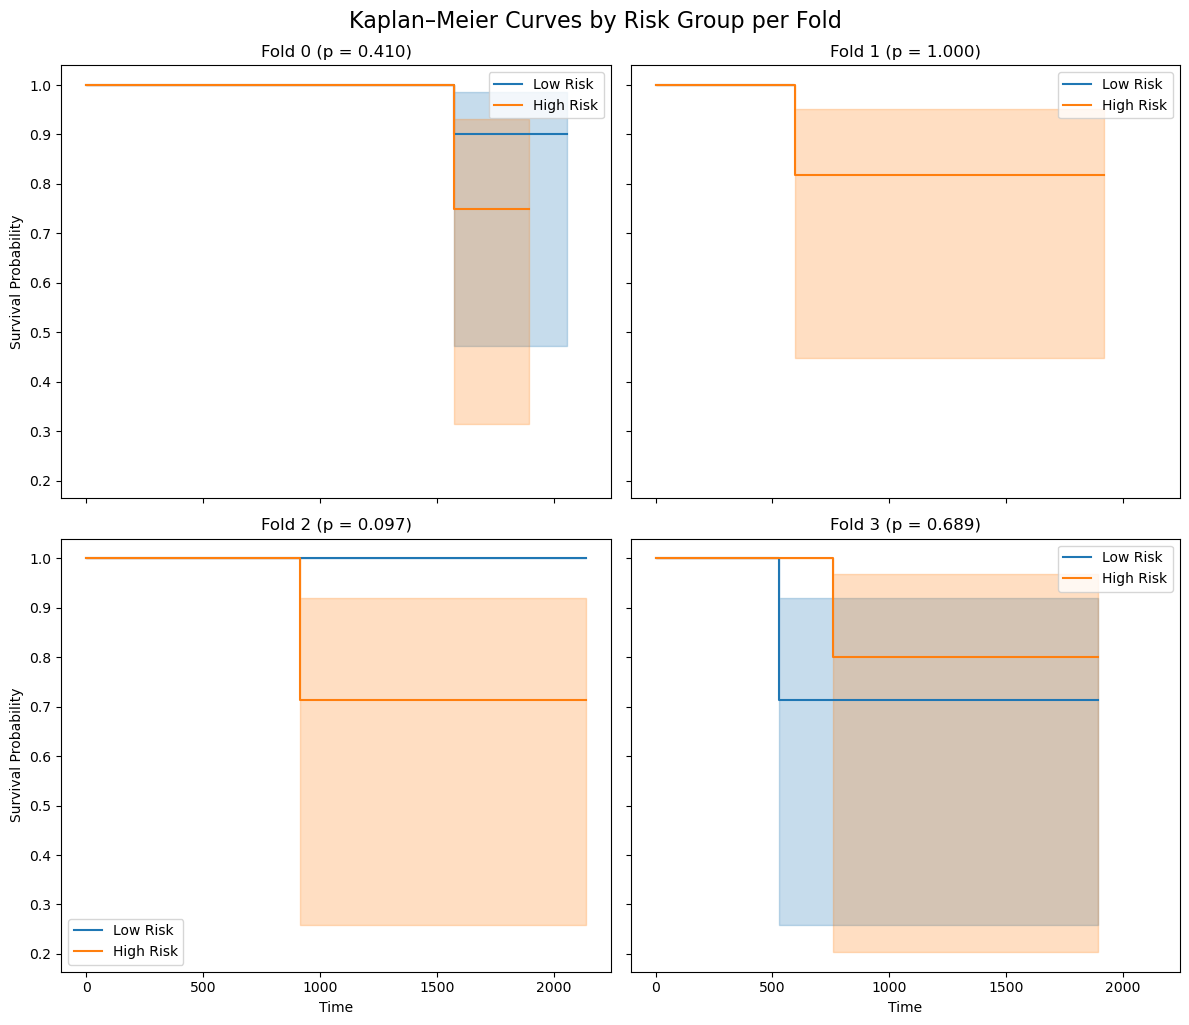


Overall Mean C-Index across folds: 0.1917 ± 0.0726


In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random
SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.
    
    Args:
        seed (int): Seed value to be used
    """
    # Python's built-in random module
    random.seed(seed)
    
    # Numpy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Configure PyTorch to make computations deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    # pairwise differences
    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    # valid: earlier event and non‐censored
    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()


folds_dir = "./models/ckpts/CPTAC_UCEC_titan_medimsight_trainfull"
test_path = "./data/processed/processed_CPTACUCEC_survival/k=all.tsv"

# Prepare a multi‐panel figure: one subplot per fold
n_folds = 4
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

fold_cindices = []
for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    # --- load model ---
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith(".pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # --- load data ---
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,                # <-- use the actual fold index here
        split="test",             # <-- split should be “test”, not “train”
        ct_path="../MedImageInsights/embeddings_cptacucec",
        wsi_path="../../trident_processed_UCEC_titan/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.30,
        require_both_modalities=True,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    # --- run inference and collect per‐patient data ---
    hazards_all = []
    times_all   = []
    events_all  = []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            # get predicted hazard (you already negate in your code)
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times   = batch["survtime"]
            events  = batch["censor"]

            # to CPU numpy
            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            # per‐batch c-index (optional)
            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    # concatenate
    hazards_all = np.concatenate(hazards_all)
    times_all   = np.concatenate(times_all)
    events_all  = np.concatenate(events_all)

    # fold c-index
    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

    # --- stratify by median risk ---
    median_risk = np.median(hazards_all)
    is_high = hazards_all >= median_risk

    # --- fit & plot KM curves ---
    ax = axes[fold]
    kmf_low  = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[~is_high],  events_all[~is_high],  label="Low Risk")
    kmf_high.fit(times_all[ is_high], events_all[ is_high], label="High Risk")

    kmf_low.plot_survival_function(ax=ax)
    kmf_high.plot_survival_function(ax=ax)

    # log-rank test
    results = statistics.logrank_test(
        times_all[~is_high], times_all[is_high],
        events_all[~is_high], events_all[is_high]
    )
    p_value = results.p_value

    ax.set_title(f"Fold {fold} (p = {p_value:.3f})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")

# --- final touches ---
fig.tight_layout()
plt.suptitle("Kaplan–Meier Curves by Risk Group per Fold", y=1.02, fontsize=16)
plt.show()

# === Final Aggregation of C-Index ===
overall_mean = mean(fold_cindices)
overall_std  = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0


/tmp/ipykernel_213173/2992607973.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 249  249  249  761  761  761  761  715  715  715  715  118  256 1104
 1104 1590  718  718  718  991  991  991  427  415  415  143  455  791
  435  479  479  479  294 1015 1015 1015   39  696  696  696  696] [False False False False False False False False False False False False
  True  True  True False False False False False False False False False
 False False False False False  True  True  True False  True  True  True
 False  True  True  True  True]
Fold 0 Mean C-Index: 0.0364

Evaluating Fold 1


/tmp/ipykernel_213173/2992607973.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 603  603  603 1063 1063 1063 1063  243  243  243  243  243  243  243
  243 1007 1007  550  596  596  596  596   78   78   78   78  246  732
  732  240  240  240  240  240  240  240  240  893  279  279 1352  449
  449 1051 1051 1051   70   70  139  139  139  393  393  393  348  348
  348  303  303] [False False False False False False False False False False False False
 False False False False False  True False False False False  True  True
  True  True False False False  True  True  True  True  True  True  True
  True False False False  True  True  True  True  True  True False False
 False False False False False False False False False False False]
Fold 1 Mean C-Index: 0.1889

Evaluating Fold 2


/tmp/ipykernel_213173/2992607973.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 610  610  610  610  610  610 1305 1305 1305 1198 1198  369  369  369
  344  344  344  344  594  594  261  261  723  723  723   91   91   91
  854  854  854  225  225  196  196 1592 1592 1592 1592 1592  323  323
  323  323  708  708   58  398  398  398  696  696  696] [False False False False False False False False False False False  True
  True  True False False False False False False  True  True False False
 False False False False False False False False False False False  True
  True  True  True  True False False False False  True  True False False
 False False  True  True  True]
Fold 2 Mean C-Index: 0.0714

Evaluating Fold 3


/tmp/ipykernel_213173/2992607973.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[1041 1041  399  399  399  287  287  287  287  276  276  276  276  276
  276  632  632  740  740  740  740  740  740  403 1503 1503  795  795
  795  241  241  754  754  400  400  398  398  430  430  430   32   32
  123  123  728  728  815  680  680  680] [False False  True  True  True False False False False False False False
 False False False False False  True  True  True  True  True  True False
  True  True False False False False False False False False False False
 False False False False  True  True False False  True  True False False
 False False]
Fold 3 Mean C-Index: 0.0962

Evaluating Fold 4


/tmp/ipykernel_213173/2992607973.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 426  426  426  426  426 1752 1752 1752  422  422  300  300  300  271
  271  271  271  913  913  913  376  376  376  376  190  190  211  211
   68   68   68   68   68   68   68 1152 1152 1152  811  811  358  358
  358  609  609  609  487  733  733  733  458  458  701  305  305  305] [ True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True  True False  True
  True  True False False False False False False]
Fold 4 Mean C-Index: 0.1905


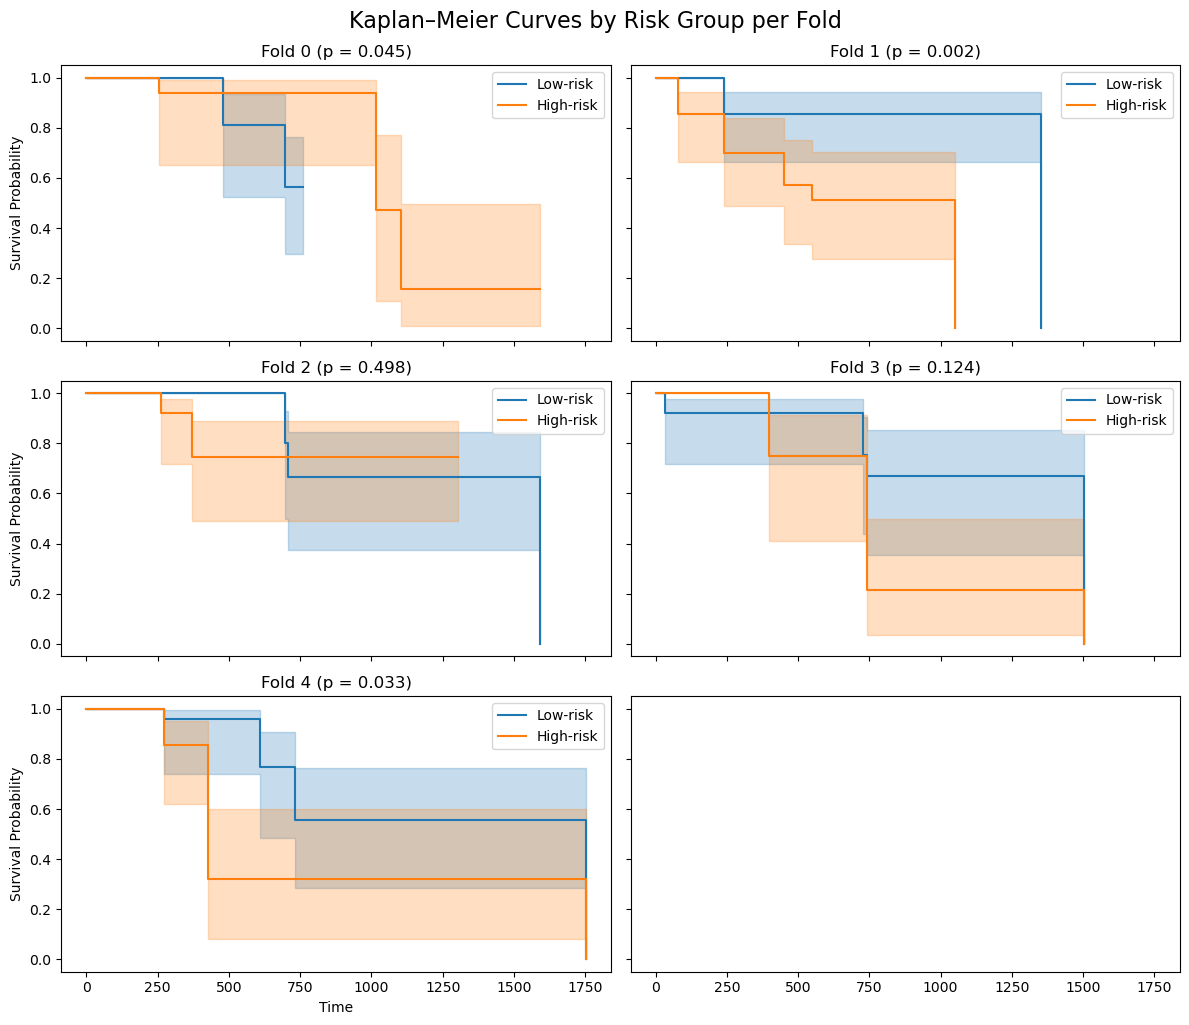


Overall Mean C-Index across folds: 0.1167 ± 0.0700


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv

import random
SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.
    
    Args:
        seed (int): Seed value to be used
    """
    # Python's built-in random module
    random.seed(seed)
    
    # Numpy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Configure PyTorch to make computations deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_global_seed()
def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    # pairwise differences
    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    # valid: earlier event and non‐censored
    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()


folds_dir = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"

# Prepare a multi‐panel figure: one subplot per fold
n_folds = 5
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

fold_cindices = []
for fold in range(n_folds):
    fold = fold
    print(f"\nEvaluating Fold {fold}")
    # --- load model ---
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith(".pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # --- load data ---
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,                # <-- use the actual fold index here
        split="test",             # <-- split should be “test”, not “train”
        ct_path= "../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path= "../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    # --- run inference and collect per‐patient data ---
    hazards_all = []
    times_all   = []
    events_all  = []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            # get predicted hazard (you already negate in your code)
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times   = batch["survtime"]
            events  = batch["censor"]

            # to CPU numpy
            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            # per‐batch c-index (optional)
            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    # concatenate
    hazards_all = np.concatenate(hazards_all)
    times_all   = np.concatenate(times_all)
    events_all  = np.concatenate(events_all)
    print(times_all, events_all)
    # fold c-index
    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")
    # --- after concatenating hazards_all, times_all, events_all ---

    # total number of patients
    n = len(hazards_all)

    # argsort gives indices that would sort hazards ascending (low risk first)
    order = np.argsort(hazards_all)

    # split point
    half = n // 2

    # indices of the low‐risk and high‐risk groups
    low_idx  = order[:half]
    high_idx = order[half:]

    # create boolean masks
    low_mask  = np.zeros(n, dtype=bool)
    high_mask = np.zeros(n, dtype=bool)
    low_mask[ low_idx]  = True
    high_mask[high_idx] = True

    # sanity check
    assert low_mask.sum() + high_mask.sum() == n

    # --- fit & plot KM curves exactly as before, but using these masks ---

    ax = axes[fold]
    kmf_low  = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask],  events_all[low_mask],  label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")

    kmf_low.plot_survival_function(ax=ax)
    kmf_high.plot_survival_function(ax=ax)

    # log‐rank test
    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"Fold {fold} (p = {results.p_value:.3f})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")


# --- final touches ---
fig.tight_layout()
plt.suptitle("Kaplan–Meier Curves by Risk Group per Fold", y=1.02, fontsize=16)
plt.show()

# === Final Aggregation of C-Index ===
overall_mean = mean(fold_cindices)
overall_std  = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")


# CPTAC-PDA evaluation

Full modality


Evaluating Fold 0


/tmp/ipykernel_920448/1271434400.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 249  249  249  761  761  761  761  715  715  715  715  118  256 1104
 1104 1590  718  718  718  991  991  991  427  415  415  143  455  791
  435  479  479  479  294 1015 1015 1015   39  696  696  696  696] [False False False False False False False False False False False False
  True  True  True False False False False False False False False False
 False False False False False  True  True  True False  True  True  True
 False  True  True  True  True]
Fold 0 Mean C-Index: 0.0364

Evaluating Fold 1


/tmp/ipykernel_920448/1271434400.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 603  603  603 1063 1063 1063 1063  243  243  243  243  243  243  243
  243 1007 1007  550  596  596  596  596   78   78   78   78  246  732
  732  240  240  240  240  240  240  240  240  893  279  279 1352  449
  449 1051 1051 1051   70   70  139  139  139  393  393  393  348  348
  348  303  303] [False False False False False False False False False False False False
 False False False False False  True False False False False  True  True
  True  True False False False  True  True  True  True  True  True  True
  True False False False  True  True  True  True  True  True False False
 False False False False False False False False False False False]
Fold 1 Mean C-Index: 0.1889

Evaluating Fold 2


/tmp/ipykernel_920448/1271434400.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 610  610  610  610  610  610 1305 1305 1305 1198 1198  369  369  369
  344  344  344  344  594  594  261  261  723  723  723   91   91   91
  854  854  854  225  225  196  196 1592 1592 1592 1592 1592  323  323
  323  323  708  708   58  398  398  398  696  696  696] [False False False False False False False False False False False  True
  True  True False False False False False False  True  True False False
 False False False False False False False False False False False  True
  True  True  True  True False False False False  True  True False False
 False False  True  True  True]
Fold 2 Mean C-Index: 0.0952

Evaluating Fold 3


/tmp/ipykernel_920448/1271434400.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[1041 1041  399  399  399  287  287  287  287  276  276  276  276  276
  276  632  632  740  740  740  740  740  740  403 1503 1503  795  795
  795  241  241  754  754  400  400  398  398  430  430  430   32   32
  123  123  728  728  815  680  680  680] [False False  True  True  True False False False False False False False
 False False False False False  True  True  True  True  True  True False
  True  True False False False False False False False False False False
 False False False False  True  True False False  True  True False False
 False False]
Fold 3 Mean C-Index: 0.0962

Evaluating Fold 4


/tmp/ipykernel_920448/1271434400.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 426  426  426  426  426 1752 1752 1752  422  422  300  300  300  271
  271  271  271  913  913  913  376  376  376  376  190  190  211  211
   68   68   68   68   68   68   68 1152 1152 1152  811  811  358  358
  358  609  609  609  487  733  733  733  458  458  701  305  305  305] [ True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True  True False  True
  True  True False False False False False False]
Fold 4 Mean C-Index: 0.1905


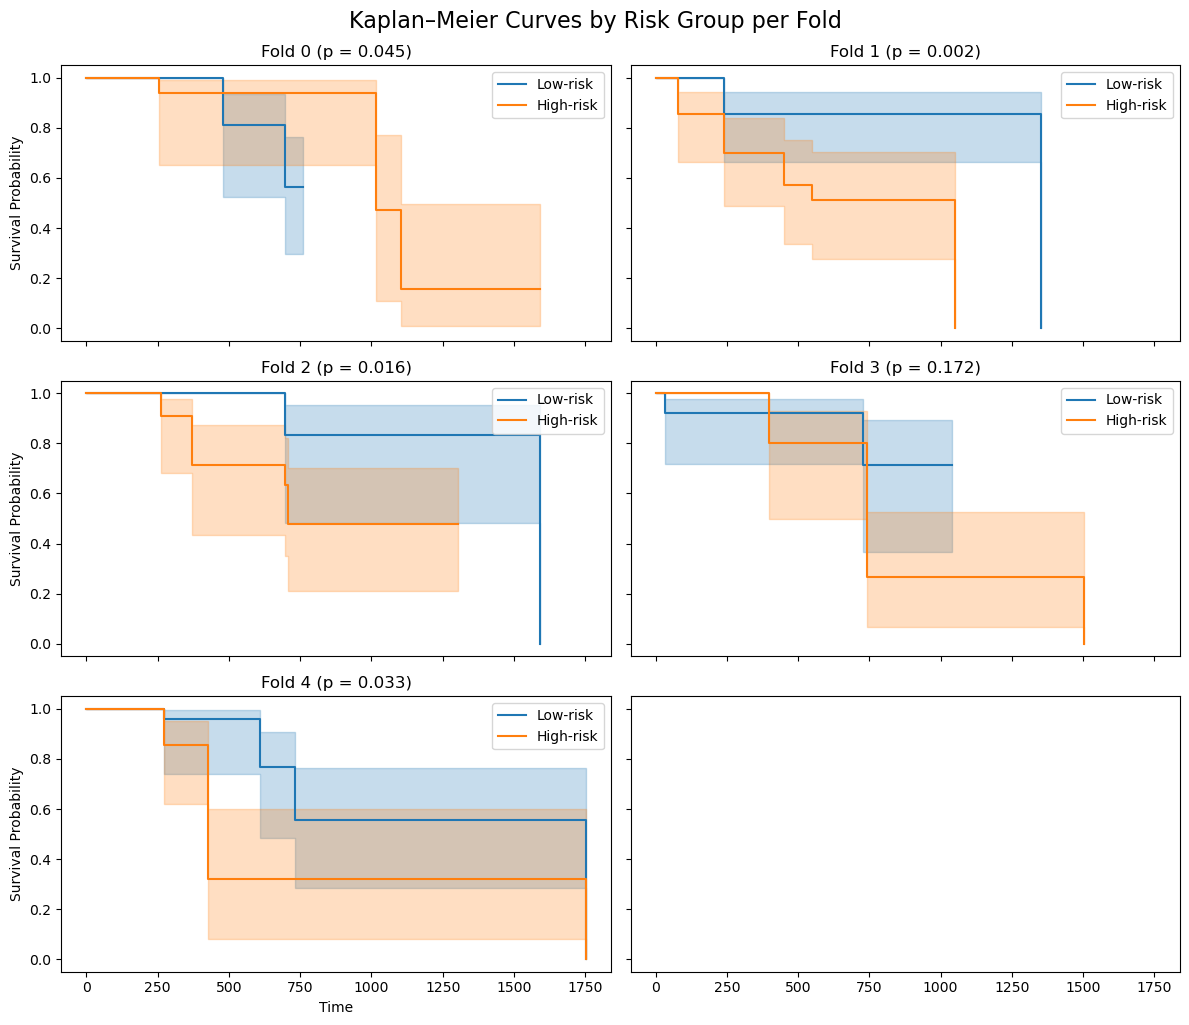


Overall Mean C-Index across folds: 0.1214 ± 0.0669


In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.
    
    Args:
        seed (int): Seed value to be used
    """
    # Python's built-in random module
    random.seed(seed)
    
    # Numpy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Configure PyTorch to make computations deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_global_seed()
def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    # pairwise differences
    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    # valid: earlier event and non‐censored
    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()


folds_dir = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"

# Prepare a multi‐panel figure: one subplot per fold
n_folds = 5
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

fold_cindices = []
for fold in range(n_folds):
    fold = fold
    print(f"\nEvaluating Fold {fold}")
    # --- load model ---
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("loss.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # --- load data ---
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,                # <-- use the actual fold index here
        split="test",             # <-- split should be “test”, not “train”
        ct_path= "../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path= "../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    # --- run inference and collect per‐patient data ---
    hazards_all = []
    times_all   = []
    events_all  = []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            # get predicted hazard (you already negate in your code)
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times   = batch["survtime"]
            events  = batch["censor"]

            # to CPU numpy
            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            # per‐batch c-index (optional)
            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    # concatenate
    hazards_all = np.concatenate(hazards_all)
    times_all   = np.concatenate(times_all)
    events_all  = np.concatenate(events_all)
    print(times_all, events_all)
    # fold c-index
    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")
    # --- after concatenating hazards_all, times_all, events_all ---

    # total number of patients
    n = len(hazards_all)

    # argsort gives indices that would sort hazards ascending (low risk first)
    order = np.argsort(hazards_all)

    # split point
    half = n // 2

    # indices of the low‐risk and high‐risk groups
    low_idx  = order[:half]
    high_idx = order[half:]

    # create boolean masks
    low_mask  = np.zeros(n, dtype=bool)
    high_mask = np.zeros(n, dtype=bool)
    low_mask[ low_idx]  = True
    high_mask[high_idx] = True

    # sanity check
    assert low_mask.sum() + high_mask.sum() == n

    # --- fit & plot KM curves exactly as before, but using these masks ---

    ax = axes[fold]
    kmf_low  = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask],  events_all[low_mask],  label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")

    kmf_low.plot_survival_function(ax=ax)
    kmf_high.plot_survival_function(ax=ax)

    # log‐rank test
    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"Fold {fold} (p = {results.p_value:.3f})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")


# --- final touches ---
fig.tight_layout()
plt.suptitle("Kaplan–Meier Curves by Risk Group per Fold", y=1.02, fontsize=16)
plt.show()

# === Final Aggregation of C-Index ===
overall_mean = mean(fold_cindices)
overall_std  = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")


In [27]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()

# Directories and data paths
folds_dir = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"

n_folds = 5
fold_cindices = []

for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    
    # Load model checkpoint
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("loss.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Load test data
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,
        split="test",
        ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    hazards_all, times_all, events_all = [], [], []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times = batch["survtime"]
            events = batch["censor"]

            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    hazards_all = np.concatenate(hazards_all)
    times_all = np.concatenate(times_all)
    events_all = np.concatenate(events_all)

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

    # Split into high/low risk
    order = np.argsort(hazards_all)
    half = len(order) // 2
    low_idx, high_idx = order[:half], order[half:]
    low_mask = np.zeros_like(order, dtype=bool)
    high_mask = np.zeros_like(order, dtype=bool)
    low_mask[low_idx] = True
    high_mask[high_idx] = True

    # Create and save individual KM plot
    fig, ax = plt.subplots(figsize=(6, 5))
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask], events_all[low_mask], label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")
    kmf_low.plot_survival_function(ax=ax)
    kmf_high.plot_survival_function(ax=ax)

    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"(p = {results.p_value:.3f})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")

    # Save each fold figure as PDF
    output_dir = "./plots"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f"km_plot_fold_{fold}.pdf")
    fig.tight_layout()
    fig.savefig(pdf_path)
    plt.close(fig)
    print(f"Saved Kaplan–Meier plot for fold {fold} to {pdf_path}")

# Aggregate C-Index
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0


/tmp/ipykernel_920448/2843008361.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 0 Mean C-Index: 0.0364
Saved Kaplan–Meier plot for fold 0 to ./plots/km_plot_fold_0.pdf

Evaluating Fold 1


/tmp/ipykernel_920448/2843008361.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 1 Mean C-Index: 0.1889
Saved Kaplan–Meier plot for fold 1 to ./plots/km_plot_fold_1.pdf

Evaluating Fold 2


/tmp/ipykernel_920448/2843008361.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 2 Mean C-Index: 0.0952
Saved Kaplan–Meier plot for fold 2 to ./plots/km_plot_fold_2.pdf

Evaluating Fold 3


/tmp/ipykernel_920448/2843008361.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 3 Mean C-Index: 0.0962
Saved Kaplan–Meier plot for fold 3 to ./plots/km_plot_fold_3.pdf

Evaluating Fold 4


/tmp/ipykernel_920448/2843008361.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 4 Mean C-Index: 0.1905
Saved Kaplan–Meier plot for fold 4 to ./plots/km_plot_fold_4.pdf

Overall Mean C-Index across folds: 0.1214 ± 0.0669


In [7]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()

# Directories and data paths
folds_dir = "./models/ckpts/CPTACPDA_trainmixed30_multival_Titan_MedImSight"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"

n_folds = 5
fold_cindices = []
colorblind_colors = {
    "G1": "#1E88E5",  # Blue
    "G2": "#FFC107",  # Vermillion
    "G3": "#D81B60",  # Black
}
for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    
    # Load model checkpoint
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("histo_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Load test data
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,
        split="test",
        ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.15,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    hazards_all, times_all, events_all = [], [], []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times = batch["survtime"]
            events = batch["censor"]

            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    hazards_all = np.concatenate(hazards_all)
    times_all = np.concatenate(times_all)
    events_all = np.concatenate(events_all)

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

    # Split into high/low risk
    order = np.argsort(hazards_all)
    half = len(order) // 2
    low_idx, high_idx = order[:half], order[half:]
    low_mask = np.zeros_like(order, dtype=bool)
    high_mask = np.zeros_like(order, dtype=bool)
    low_mask[low_idx] = True
    high_mask[high_idx] = True

    # Create and save individual KM plot
    fig, ax = plt.subplots(figsize=(6, 5))
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask], events_all[low_mask], label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")
    kmf_low.plot_survival_function(ax=ax, color=colorblind_colors["G1"])
    kmf_high.plot_survival_function(ax=ax,color=colorblind_colors["G3"])

    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"(p = {results.p_value:.3e})", fontsize=18)
    ax.set_xlabel("Time", fontsize=16)
    ax.set_ylabel("Survival Probability", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.legend(fontsize=14)
    # Save each fold figure as PDF
    output_dir = "./plots"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f"missingMORE_km_plot_fold_{fold}.pdf")
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(pdf_path)
    plt.close(fig)
    print(f"Saved Kaplan–Meier plot for fold {fold} to {pdf_path}")

# Aggregate C-Index
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0


/tmp/ipykernel_2709582/974000395.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 0 Mean C-Index: 0.0727
Saved Kaplan–Meier plot for fold 0 to ./plots/missingMORE_km_plot_fold_0.pdf

Evaluating Fold 1


/tmp/ipykernel_2709582/974000395.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 1 Mean C-Index: 0.0978
Saved Kaplan–Meier plot for fold 1 to ./plots/missingMORE_km_plot_fold_1.pdf

Evaluating Fold 2


/tmp/ipykernel_2709582/974000395.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 2 Mean C-Index: 0.1429
Saved Kaplan–Meier plot for fold 2 to ./plots/missingMORE_km_plot_fold_2.pdf

Evaluating Fold 3


/tmp/ipykernel_2709582/974000395.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 3 Mean C-Index: 0.1923
Saved Kaplan–Meier plot for fold 3 to ./plots/missingMORE_km_plot_fold_3.pdf

Evaluating Fold 4


/tmp/ipykernel_2709582/974000395.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 4 Mean C-Index: 0.2500
Saved Kaplan–Meier plot for fold 4 to ./plots/missingMORE_km_plot_fold_4.pdf

Overall Mean C-Index across folds: 0.1511 ± 0.0716


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()

# Directories and data paths
folds_dir = "./models/ckpts/CPTACPDA_trainmixed30_multival_Titan_MedImSight"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"

n_folds = 5
fold_cindices = []

for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    
    # Load model checkpoint
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("histo_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Load test data
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,
        split="test",
        ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    hazards_all, times_all, events_all = [], [], []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times = batch["survtime"]
            events = batch["censor"]

            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    hazards_all = np.concatenate(hazards_all)
    times_all = np.concatenate(times_all)
    events_all = np.concatenate(events_all)

    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")

    # Split into high/low risk
    order = np.argsort(hazards_all)
    half = len(order) // 2
    low_idx, high_idx = order[:half], order[half:]
    low_mask = np.zeros_like(order, dtype=bool)
    high_mask = np.zeros_like(order, dtype=bool)
    low_mask[low_idx] = True
    high_mask[high_idx] = True

    # Create and save individual KM plot
    fig, ax = plt.subplots(figsize=(6, 5))
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask], events_all[low_mask], label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")
    kmf_low.plot_survival_function(ax=ax)
    kmf_high.plot_survival_function(ax=ax)

    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"(p = {results.p_value:.3e})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")

    # Save each fold figure as PDF
    output_dir = "./plots"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f"UCECmissing_km_plot_fold_{fold}.pdf")
    fig.tight_layout()
    fig.savefig(pdf_path)
    plt.close(fig)
    print(f"Saved Kaplan–Meier plot for fold {fold} to {pdf_path}")

# Aggregate C-Index
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.

    Args:
        seed (int): Seed value to be used
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed()

def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()

# Directories and data paths
folds_dir = "./models/ckpts/CPTACPDA_medimsight_titan_CTOnly_NEWMODEL2.6Skip_GCS_controller"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"

n_folds = 5
fold_cindices = []

for fold in range(n_folds):
    print(f"\nEvaluating Fold {fold}")
    
    # Load model checkpoint
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("loss.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Load test data
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,
        split="test",
        ct_path="../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path="../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    hazards_list, times_list, events_list = [], [], []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])['hazard'].squeeze()
            times = batch["survtime"]
            events = batch["censor"]

            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_list.append(h_np)
            times_list.append(t_np)
            events_list.append(e_np)

            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    hazards_all = np.concatenate(hazards_list)
    times_all = np.concatenate(times_list)
    events_all = np.concatenate(events_list)

    fold_mean_cidx = mean(batch_cindices)
    fold_cindices.append(fold_mean_cidx)
    print(f"Fold {fold} Mean C-Index: {fold_mean_cidx:.4f}")

    # Divide by mean hazard score
    mean_hazard = hazards_all.mean()
    low_mask = hazards_all <= mean_hazard
    high_mask = hazards_all > mean_hazard

    # Create and save individual KM plot
    fig, ax = plt.subplots(figsize=(6, 5))
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask], events_all[low_mask], label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")
    kmf_low.plot_survival_function(ax=ax)
    kmf_high.plot_survival_function(ax=ax)

    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"Fold {fold} (p = {results.p_value:.3f})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")

    output_dir = "./plots"
    os.makedirs(output_dir, exist_ok=True)
    pdf_path = os.path.join(output_dir, f"km_plot_fold_{fold}.pdf")
    fig.tight_layout()
    fig.savefig(pdf_path)
    plt.close(fig)
    print(f"Saved Kaplan–Meier plot for fold {fold} to {pdf_path}")

# Aggregate C-Index
overall_mean = mean(fold_cindices)
overall_std = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")



Evaluating Fold 0


/tmp/ipykernel_2709582/112074561.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 0 Mean C-Index: 0.0364
Saved Kaplan–Meier plot for fold 0 to ./plots/km_plot_fold_0.pdf

Evaluating Fold 1


/tmp/ipykernel_2709582/112074561.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 1 Mean C-Index: 0.1889
Saved Kaplan–Meier plot for fold 1 to ./plots/km_plot_fold_1.pdf

Evaluating Fold 2


/tmp/ipykernel_2709582/112074561.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 2 Mean C-Index: 0.0952
Saved Kaplan–Meier plot for fold 2 to ./plots/km_plot_fold_2.pdf

Evaluating Fold 3


/tmp/ipykernel_2709582/112074561.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 3 Mean C-Index: 0.0962
Saved Kaplan–Meier plot for fold 3 to ./plots/km_plot_fold_3.pdf

Evaluating Fold 4


/tmp/ipykernel_2709582/112074561.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


Fold 4 Mean C-Index: 0.1905
Saved Kaplan–Meier plot for fold 4 to ./plots/km_plot_fold_4.pdf

Overall Mean C-Index across folds: 0.1214 ± 0.0669



Evaluating Fold 0


/tmp/ipykernel_920448/3592020270.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 249  249  249  761  761  761  761  715  715  715  715  118  256 1104
 1104 1590  718  718  718  991  991  991  427  415  415  143  455  791
  435  479  479  479  294 1015 1015 1015   39  696  696  696  696] [False False False False False False False False False False False False
  True  True  True False False False False False False False False False
 False False False False False  True  True  True False  True  True  True
 False  True  True  True  True]
Fold 0 Mean C-Index: 0.0727

Evaluating Fold 1


/tmp/ipykernel_920448/3592020270.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 603  603  603 1063 1063 1063 1063  243  243  243  243  243  243  243
  243 1007 1007  550  596  596  596  596   78   78   78   78  246  732
  732  240  240  240  240  240  240  240  240  893  279  279 1352  449
  449 1051 1051 1051   70   70  139  139  139  393  393  393  348  348
  348  303  303] [False False False False False False False False False False False False
 False False False False False  True False False False False  True  True
  True  True False False False  True  True  True  True  True  True  True
  True False False False  True  True  True  True  True  True False False
 False False False False False False False False False False False]
Fold 1 Mean C-Index: 0.1200

Evaluating Fold 2


/tmp/ipykernel_920448/3592020270.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 610  610  610  610  610  610 1305 1305 1305 1198 1198  369  369  369
  344  344  344  344  594  594  261  261  723  723  723   91   91   91
  854  854  854  225  225  196  196 1592 1592 1592 1592 1592  323  323
  323  323  708  708   58  398  398  398  696  696  696] [False False False False False False False False False False False  True
  True  True False False False False False False  True  True False False
 False False False False False False False False False False False  True
  True  True  True  True False False False False  True  True False False
 False False  True  True  True]
Fold 2 Mean C-Index: 0.1250

Evaluating Fold 3


/tmp/ipykernel_920448/3592020270.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[1041 1041  399  399  399  287  287  287  287  276  276  276  276  276
  276  632  632  740  740  740  740  740  740  403 1503 1503  795  795
  795  241  241  754  754  400  400  398  398  430  430  430   32   32
  123  123  728  728  815  680  680  680] [False False  True  True  True False False False False False False False
 False False False False False  True  True  True  True  True  True False
  True  True False False False False False False False False False False
 False False False False  True  True False False  True  True False False
 False False]
Fold 3 Mean C-Index: 0.1923

Evaluating Fold 4


/tmp/ipykernel_920448/3592020270.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))


[ 426  426  426  426  426 1752 1752 1752  422  422  300  300  300  271
  271  271  271  913  913  913  376  376  376  376  190  190  211  211
   68   68   68   68   68   68   68 1152 1152 1152  811  811  358  358
  358  609  609  609  487  733  733  733  458  458  701  305  305  305] [ True  True  True  True  True  True  True  True False False False False
 False  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True  True False  True
  True  True False False False False False False]
Fold 4 Mean C-Index: 0.2500


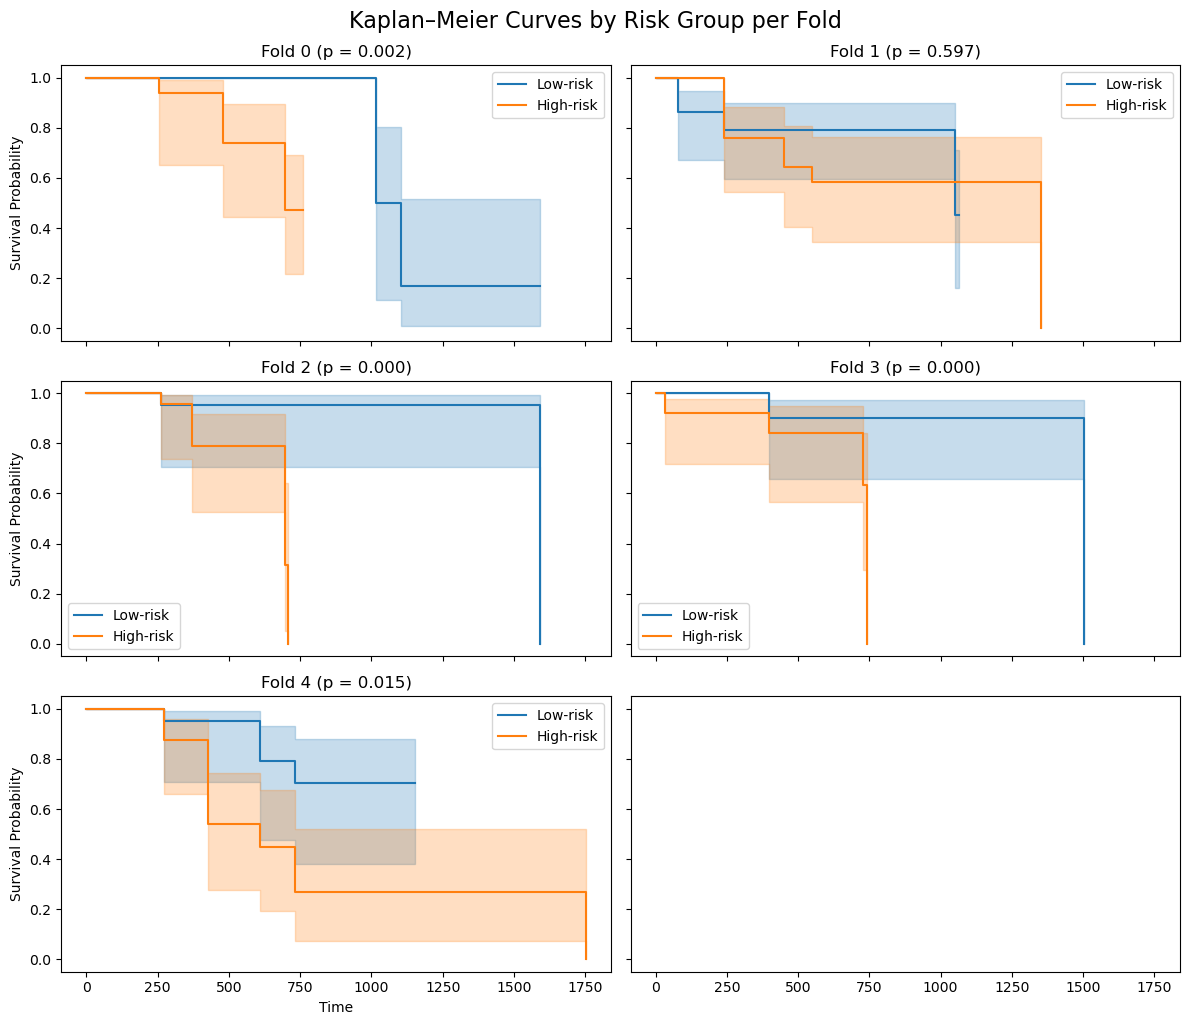


Overall Mean C-Index across folds: 0.1520 ± 0.0694


In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from lifelines import KaplanMeierFitter, statistics

from data.multimodal_features_surv import MultimodalCTWSIDatasetSurv
from torch.utils.data import DataLoader
from models.dpe.main_model_nobackbone_surv_new_gcs import MADPENetNoBackbonesSurv
import random

SEED = 0

def set_global_seed(seed=SEED):
    """
    Set a global seed for reproducibility across different libraries and random number generators.
    
    Args:
        seed (int): Seed value to be used
    """
    # Python's built-in random module
    random.seed(seed)
    
    # Numpy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Configure PyTorch to make computations deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_global_seed()
def concordance_index_torch(
    predicted_scores: torch.Tensor,
    event_times: torch.Tensor,
    event_observed: torch.Tensor,
    eps: float = 1e-8,
) -> float:
    """Compute Harrell’s C‐index in pure PyTorch."""
    predicted_scores = predicted_scores.flatten()
    event_times = event_times.flatten()
    event_observed = event_observed.flatten()

    # pairwise differences
    dt = event_times.unsqueeze(0) - event_times.unsqueeze(1)
    ds = predicted_scores.unsqueeze(0) - predicted_scores.unsqueeze(1)

    # valid: earlier event and non‐censored
    valid = (dt < 0) & (event_observed.unsqueeze(0) == 1)
    concordant = (ds > 0) & valid
    tied = (ds.abs() < eps) & valid

    c_sum = concordant.sum(dtype=torch.float32)
    t_sum = tied.sum(dtype=torch.float32)
    v_sum = valid.sum(dtype=torch.float32)

    c_index = (c_sum + 0.5 * t_sum) / (v_sum + eps)
    return c_index.item()


folds_dir = "./models/ckpts/CPTACPDA_trainmixed30_multival_Titan_MedImSight"
test_path = "./data/processed/processed_CPTAC_PDA_survival/k=all.tsv"

# Prepare a multi‐panel figure: one subplot per fold
n_folds = 5
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

fold_cindices = []
for fold in range(n_folds):
    fold = fold
    print(f"\nEvaluating Fold {fold}")
    # --- load model ---
    model = MADPENetNoBackbonesSurv(
        rad_input_dim=1024,
        histo_input_dim=768,
        inter_dim=256,
        token_dim=256,
        dim_hider=256
    )
    fold_dir = os.path.join(folds_dir, f"fold_{fold}")
    model_dir = next(d for d in os.listdir(fold_dir) if os.path.isdir(os.path.join(fold_dir, d)))
    model_file = next(f for f in os.listdir(os.path.join(fold_dir, model_dir)) if f.endswith("histo_missing.pth"))
    checkpoint = torch.load(os.path.join(fold_dir, model_dir, model_file))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # --- load data ---
    test_dataset = MultimodalCTWSIDatasetSurv(
        fold=fold,                # <-- use the actual fold index here
        split="test",             # <-- split should be “test”, not “train”
        ct_path= "../MedImageInsights/embeddings_output_cptacpda_93",
        wsi_path= "../../TitanCPTACPDA/20x_512px_0px_overlap/slide_features_titan",
        labels_splits_path=test_path,
        missing_modality_prob=0.0,
        require_both_modalities=False,
        pairing_mode="one_to_one",
        allow_repeats=True,
        pairs_per_patient=None
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    # --- run inference and collect per‐patient data ---
    hazards_all = []
    times_all   = []
    events_all  = []
    batch_cindices = []

    with torch.no_grad():
        for batch in test_loader:
            # get predicted hazard (you already negate in your code)
            hazard = model(batch["ct_feature"], batch["wsi_feature"], batch["modality_mask"])["hazard"].squeeze()
            times   = batch["survtime"]
            events  = batch["censor"]

            # to CPU numpy
            h_np = hazard.cpu().numpy().flatten()
            t_np = times.cpu().numpy().flatten()
            e_np = events.cpu().numpy().flatten()

            hazards_all.append(h_np)
            times_all.append(t_np)
            events_all.append(e_np)

            # per‐batch c-index (optional)
            cidx = concordance_index_torch(predicted_scores=hazard,
                                           event_times=times,
                                           event_observed=events)
            batch_cindices.append(cidx)

    # concatenate
    hazards_all = np.concatenate(hazards_all)
    times_all   = np.concatenate(times_all)
    events_all  = np.concatenate(events_all)
    print(times_all, events_all)
    # fold c-index
    fold_mean = mean(batch_cindices)
    fold_cindices.append(fold_mean)
    print(f"Fold {fold} Mean C-Index: {fold_mean:.4f}")
    # --- after concatenating hazards_all, times_all, events_all ---

    # total number of patients
    n = len(hazards_all)

    # argsort gives indices that would sort hazards ascending (low risk first)
    order = np.argsort(hazards_all)

    # split point
    half = n // 2

    # indices of the low‐risk and high‐risk groups
    low_idx  = order[:half]
    high_idx = order[half:]

    # create boolean masks
    low_mask  = np.zeros(n, dtype=bool)
    high_mask = np.zeros(n, dtype=bool)
    low_mask[ low_idx]  = True
    high_mask[high_idx] = True

    # sanity check
    assert low_mask.sum() + high_mask.sum() == n

    # --- fit & plot KM curves exactly as before, but using these masks ---

    ax = axes[fold]
    kmf_low  = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

    kmf_low.fit(times_all[low_mask],  events_all[low_mask],  label="Low-risk")
    kmf_high.fit(times_all[high_mask], events_all[high_mask], label="High-risk")

    kmf_low.plot_survival_function(ax=ax)
    kmf_high.plot_survival_function(ax=ax)

    # log‐rank test
    results = statistics.logrank_test(
        times_all[low_mask], times_all[high_mask],
        events_all[low_mask], events_all[high_mask]
    )
    ax.set_title(f"Fold {fold} (p = {results.p_value:.3f})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")


# --- final touches ---
fig.tight_layout()
plt.suptitle("Kaplan–Meier Curves by Risk Group per Fold", y=1.02, fontsize=16)
plt.show()

# === Final Aggregation of C-Index ===
overall_mean = mean(fold_cindices)
overall_std  = stdev(fold_cindices)
print(f"\nOverall Mean C-Index across folds: {overall_mean:.4f} ± {overall_std:.4f}")
